# ODE Prior - Strong Constrained

In this tutorial, we look at the ODE prior for the Lorenz-63 model using the weak-constrained formulation.


In [1]:
import os, sys

jaxsw_path = "/Users/eman/code_projects/jaxsw"
sys.path.append(jaxsw_path)

In [2]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [3]:
ds_sol = xr.open_dataset("./data/sim_l63.nc")
ds_sol

<xarray.Dataset>
Dimensions:              (time: 200, component: 3, realization: 1000)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation           (component, realization, time) float32 ...
    observations         (component, realization, time) float32 ...
    observations_noise   (component, realization, time) float64 ...
    observations_interp  (component, realization, time) float64 ...

## Inverse Problem

In [4]:
realization = 100

ds_trajectory = ds_sol.sel(realization=realization)
ds_trajectory

<xarray.Dataset>
Dimensions:              (time: 200, component: 3)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Data variables:
    simulation           (component, time) float32 ...
    observations         (component, time) float32 ...
    observations_noise   (component, time) float64 ...
    observations_interp  (component, time) float64 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


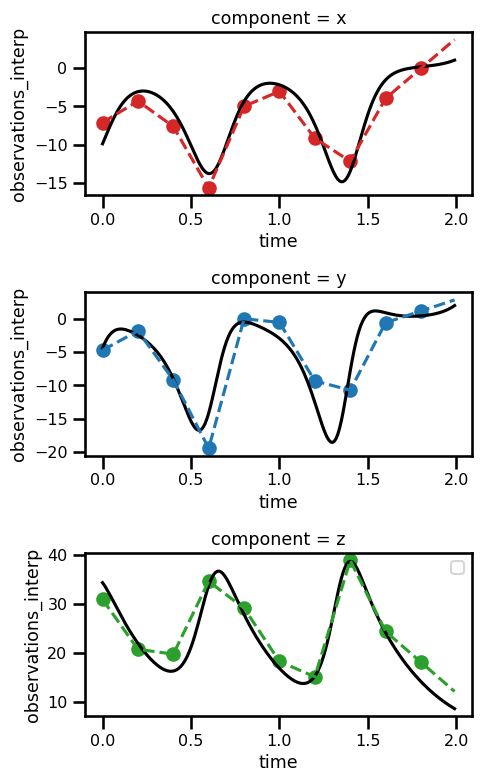

In [5]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))


ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

ds_trajectory.observations_noise.sel(component="x").plot.scatter(
    ax=ax[0], color="tab:red"
)
ds_trajectory.observations_noise.sel(component="y").plot.scatter(
    ax=ax[1], color="tab:blue"
)
ds_trajectory.observations_noise.sel(component="z").plot.scatter(
    ax=ax[2], color="tab:green"
)

ds_trajectory.observations_interp.sel(component="x").plot(
    ax=ax[0], color="tab:red", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="y").plot(
    ax=ax[1], color="tab:blue", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="z").plot(
    ax=ax[2], color="tab:green", linestyle="--"
)

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

## Data

For this problem we need the following variables

**True State**: $\boldsymbol{u}$

**Time Steps**: $\boldsymbol{\Tau}$

**Observations**: $\boldsymbol{y}$

**Initial State**: $\boldsymbol{u}^{(k)}$

**Mask**: $\boldsymbol{m}$

In [6]:
# Ground Truth
x_state = jnp.asarray(ds_trajectory.simulation.values).T
ts_state = jnp.asarray(ds_trajectory.time.values)
# Observations
y_gt = jnp.asarray(ds_trajectory.observations_noise.values).T
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_trajectory.observations_noise.values))
    .astype(jnp.float32)
    .T
)
# initialization
x_init = jnp.asarray(ds_trajectory.observations_interp.values).T

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((200, 3), (200, 3), (200, 3), (200, 3))

## Dynamical Prior

Here, we define our dynamical prior which we plug into this loss function.

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
||\boldsymbol{u} - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$

Our dynamical prior in this case is defined by:

$$
\boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta}) \coloneqq
\boldsymbol{u}(t_1) =
\boldsymbol{u}(t_0) + \int_{t_0}^{t_1}
\boldsymbol{F}\left( \boldsymbol{u}(t),\tau;\boldsymbol{\theta}\right)d\tau 
$$



**Strong Constrained**

The strong-constrained version works by applying the solver directly through the entire trajectory from start to finish.
We are sure to output the state during moments of the trajectory to ensure that we can check to ensure that we can check out how well they match the observations.
So, the function will look something like:

$$
\left[ \boldsymbol{u}_T, \boldsymbol{u}_{T-\Delta t}, \ldots, \boldsymbol{u}_{\Delta t}, \boldsymbol{u}_0\right] = 
\text{ODESolve}\left(\boldsymbol{F}, \boldsymbol{u}_0, T, \Delta t, \boldsymbol{\theta}, \right)
$$

whereby we get a matrix, $\mathbf{U}\in\mathbb{R}^{D_T\times D_u}$, which contains all of the state vectors for every time step of interest.
So our $\boldsymbol{\phi}$ operator will be

$$
\mathbf{U} = \boldsymbol{\phi}(\boldsymbol{u},t;\boldsymbol{\theta})
$$

and our cost function will be

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})_t||_2^2
$$

In [7]:
from jejeqx._src.fourdvar.priors.dynamical import Strong4DVar
from jaxsw import L63State, L63Params

In [8]:
import typing as tp
from jaxtyping import Array, PyTree

class L63Prior(Strong4DVar):

    def init_state(self, x: PyTree) -> PyTree:
        # state = L63State(
        #     x=jnp.atleast_1d(x[0]), 
        #     y=jnp.atleast_1d(x[1]), 
        #     z=jnp.atleast_1d(x[2])
        # )
        state = L63State(
            x=x[0], 
            y=x[1], 
            z=x[2]
        )
        return state

In [9]:
# init dynamical system
l63_model = Lorenz63()
params = L63Params(sigma=10, rho=28, beta=2.667)

# init dynamical prior
prior = L63Prior(params=params, model=l63_model.equation_of_motion)

In [10]:
out = prior(x=x_init[0], ts=ts_state)
out.x.shape, ts_state.shape

((200,), (200,))

In [11]:
out.array.shape

(200, 3)

### Learning

In this instance, we're going to use a simple gradient descent scheme.

$$
\boldsymbol{u}^{(k+1)} =
\boldsymbol{u}^{(k)} +
\alpha \boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

where $\alpha$ is the learning rate and $\boldsymbol{\nabla_u}$ is the gradient operator wrt the state, $\boldsymbol{u}$.
We have an optimality condition of the gradient of the variational cost.

$$
\boldsymbol{F_g}(\boldsymbol{u};\boldsymbol{\theta}) =
\boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

Because we are doing gradient *descent*, we will use a negative learning rate of $\alpha=-0.1$.

For this first part, we're simply going to use the variational cost as the dynamical prior.

$$
\begin{aligned}
\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta}) &=
\boldsymbol{R}(\boldsymbol{u};\boldsymbol{\theta}) \\
&=
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
\end{aligned}
$$

## Observation Operator

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{H}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$


We can use a simpler loss function which is just a masking operator.

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{u}||_{\Omega_{obs}}^2
$$

where $\Omega_{obs}$ is the domain of the observation.

In [12]:
from jejeqx._src.fourdvar.operators.base import ObsOperator

obs_operator = ObsOperator()

obs_operator.loss(x_init, y_gt, y_mask)

Array(0., dtype=float32)

## Variational Cost

In [13]:
from jejeqx._src.fourdvar.varcost.dynamical import StrongVarCost

In [54]:
# compute initial condition
x = x_init.copy()
x_gt = x_state.copy()

# init dynamical system
l63_model = Lorenz63()
params = L63Params(sigma=10, rho=28, beta=2.667)

# init dynamical prior
prior = L63Prior(params=params, model=l63_model.equation_of_motion)
# initialize observation operator
obs_operator = ObsOperator()
# initialize variational cost function
prior_weight = 1.0
obs_op_weight = 0.1
background_weight = 0.1
varcost_fn = StrongVarCost(
    prior=prior, 
    obs_op=obs_operator, 
    prior_weight=prior_weight, 
    obs_op_weight=obs_op_weight, 
    background_weight=background_weight
)


# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state[0], ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True)

In [55]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)

True State vs True State
{'var_loss': Array(13.003476, dtype=float32), 'obs': Array(130.03476, dtype=float32), 'bg': Array(13.003476, dtype=float32)}
Init X vs Init State
{'var_loss': Array(172.8477, dtype=float32), 'obs': Array(1728.477, dtype=float32), 'bg': Array(172.8477, dtype=float32)}


### Learning

In [56]:
import functools as ft


loss_fn = ft.partial(varcost_fn.loss, ts=ts_state, y=y_gt, mask=y_mask, xb=x_state[0], return_loss=True)
# create grad loss function
grad_loss_fn = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

In [57]:
x0.shape

(3,)

In [58]:
from tqdm.autonotebook import trange

losses = dict(prior=[], obs=[], bg=[], var_loss=[])
num_iterations = 100
learning_rate = - 0.2
x0 = x_init.copy()[0]

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:

        # get dynamical loss + gradient
        (_, loss), x_grad = grad_loss_fn(x0)

        losses["var_loss"].append(loss["var_loss"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # clip gradients (prevent explosion)
        x_grad = jnp.clip(x_grad, a_min=-0.5, a_max=0.5)

        # update solution with gradient
        x0 += learning_rate * x_grad

Var Loss: 1.58e+01 | Obs - 1.52e+02 | BG - 1.58e+01: 100%|██████████| 100/100 [00:02<00:00, 47.09it/s]


In [59]:
# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_sol_true, losses_sol_true = varcost_fn.loss(x=x0, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)


In [60]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)
print("Sol State vs True State")
print(losses_sol_true)

True State vs True State
{'var_loss': Array(13.003476, dtype=float32), 'obs': Array(130.03476, dtype=float32), 'bg': Array(13.003476, dtype=float32)}
Init X vs Init State
{'var_loss': Array(172.8477, dtype=float32), 'obs': Array(1728.477, dtype=float32), 'bg': Array(172.8477, dtype=float32)}
Sol State vs True State
{'var_loss': Array(16.048521, dtype=float32), 'obs': Array(160.4852, dtype=float32), 'bg': Array(16.048521, dtype=float32)}


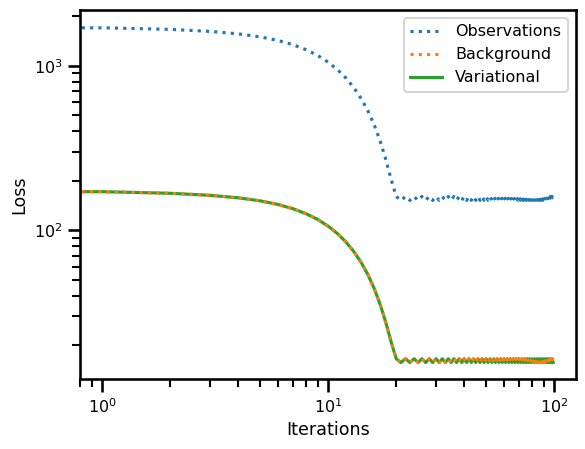

In [61]:
fig, ax = plt.subplots()

ax.plot(losses["obs"], label="Observations", linestyle=":")
ax.plot(losses["bg"], label="Background", linestyle=":")
ax.plot(losses["var_loss"], label="Variational", zorder=0)

ax.set(
    yscale="log",
    xscale="log",
    xlabel="Iterations", 
    ylabel="Loss"
)

plt.legend()
plt.show()

In [62]:
x = prior(x0, ts_state)
x = x.array
x0.shape, x.shape

((3,), (200, 3))

In [63]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float32 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float32 -9.17 -8.533 -7.92 ... 11.21 11.4
    state           (component, time) float32 -9.898 -9.344 ... 8.837 8.624
    initialization  (component, time) float32 -7.121 -6.98 ... 12.45 12.13
    observation     (component, time) float32 -7.121 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


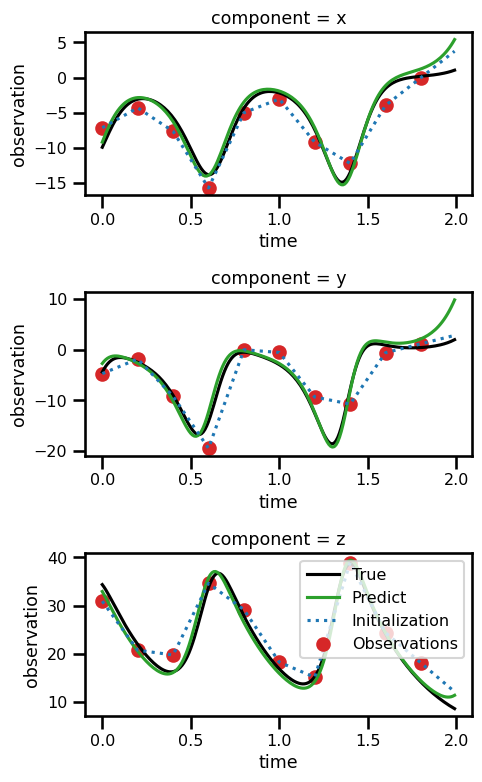

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    plt.legend()


# plt.legend()
plt.tight_layout()
plt.show()